In this notebook, we will use a Actor-Critic model to solve the CartPole environment by reinforcement learning. First, we will implement our Actor-Critic model:

In [1]:
import warnings
warnings.simplefilter("ignore")
import gym
import numpy as np
import torch
import torch.nn as nn
from torch.nn import Linear
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical
from PIL import Image
import matplotlib.pyplot as plt
torch.manual_seed(42)


class ActorCritic(nn.Module):
    def __init__(self, num_states, num_actions, num_hidden):
        super(ActorCritic, self).__init__()
        self.num_actions = num_states
        self.shared = Linear(num_states, num_hidden)       
        self.critic = Linear(num_hidden, 1)
        self.actor = Linear(num_hidden, num_actions)
    
    def forward(self, state):
        state = torch.from_numpy(state).float()
        # Actor
        action_probs = self.shared(state)
        action_probs = F.relu(action_probs)
        action_probs = self.actor(action_probs)
        action_probs = F.softmax(action_probs, dim=-1)
        
        # Critic
        critic_val = self.shared(state)
        critic_val = F.relu(critic_val)
        critic_val = self.critic(critic_val)
        return action_probs, critic_val

Next, we implement a class that brokers all our interactions between the environment and the Actor-Critic model, including training:

In [2]:
class Agent:
    def __init__(self, env, model, path_model_pars=None):
        self.env = env
        self.model = model
        if path_model_pars is not None:
            self.model.load_state_dict(torch.load(path_model_pars))
            self.model.eval()
        self._reset()

    def _reset(self):
        self.state = self.env.reset()
        self.action_history = []
        self.critic_history = []
        self.reward_history = []
        self.frames = []
    
    def _select_action(self):
        action_probs, critic_val = self.model(self.state)
        distribution = Categorical(action_probs)
        action = distribution.sample()
        self.action_history.append(distribution.log_prob(action))
        self.critic_history.append(critic_val)
        return action.item()
    
    def take_action(self, render=False):
        action = self._select_action()
        next_state, reward, terminated, _ = self.env.step(action)
        self.reward_history.append(reward)
        self.state = next_state
        if render:
            self.frames.append(
                Image.fromarray(self.env.render(mode="rgb_array")))
            self.env.close()
        if terminated:
            return terminated
        
    def _optimize_model(self, gamma):
        discounted_reward = 0
        discounted_rewards = []
        actor_loss = []
        critic_loss = []
        
        for reward in self.reward_history[::-1]:
            discounted_reward = reward + gamma * discounted_reward
            discounted_rewards.insert(0, discounted_reward)
            
        discounted_rewards = torch.tensor(
            discounted_rewards, dtype=torch.float32)
        discounted_rewards = (
            (discounted_rewards - discounted_rewards.mean()) / 
            (discounted_rewards.std() + np.finfo(np.float32).eps))
        
        for (action_log_prob, critic_val, reward) in zip(
                self.action_history, self.critic_history, discounted_rewards):
            advantage = reward - critic_val
            actor_loss.append((-action_log_prob * advantage))
            critic_loss.append(
                F.huber_loss(critic_val, reward.unsqueeze(0)))
        self.optimizer.zero_grad()
        loss = torch.stack(actor_loss).sum() + torch.stack(critic_loss).sum()
        loss.backward()
        self.optimizer.step()
        self._reset()
    
    def _reset_model(self):
        for layer in self.model.children():
            if hasattr(layer, "reset_parameters"):
                layer.reset_parameters()
    
    def _save_model(self, path):
        torch.save(self.model.state_dict(), path)
        
    def _save_animation(self, path="./animation.gif"):
        self.frames[0].save(
            path, save_all=True, append_images=self.frames[0:], fps=40, 
            loop=0)
        
    def train(self, max_episodes, max_steps_per_episode, lr, gamma, plot=True,
              progress_interval=25, save_model=True, path_save_model="./model"):
        self._reset_model()
        self.optimizer = optim.Adam(self.model.parameters(), lr=lr)
        self.running_reward_history = []
        self.episode_reward_history = []
        
        running_reward = 0
        running_reward_max = 0
        for idx_episode in range(max_episodes):
            self._reset()
            episode_reward = 0
            for idx_step in range(max_steps_per_episode):
                terminated = self.take_action()
                episode_reward += self.reward_history[-1]
                if terminated:
                    break
            self._optimize_model(gamma)
            running_reward = 0.05 * episode_reward + 0.95 * running_reward
            self.running_reward_history.append(running_reward)
            self.episode_reward_history.append(episode_reward)
            
            if (running_reward > running_reward_max) & save_model:
                running_reward_max = running_reward
                self._save_model(path_save_model)
            if idx_episode % progress_interval == 0:
                print(
                    f"Episode: {str(idx_episode).zfill(4)}; Running reward: {running_reward:.1f}.")
            if running_reward > self.env.spec.reward_threshold:
                print(f"Episode: {idx_episode}: Success")
                break
        self.episodes = list(range(idx_episode+1))
        if plot:
            self._plot_train_loss()
                
    def _plot_train_loss(self):
        fig, ax_a = plt.subplots()
        ax_a.plot(self.episodes, self.running_reward_history, color="b")
        ax_a.set_xlabel("Episode")
        ax_a.set_ylabel("Running reward", color="b")
        
        ax_b = ax_a.twinx() 
        ax_b.scatter(self.episodes, self.episode_reward_history, color="r", 
                     s=2, alpha=0.6)
        ax_b.set_ylabel("Episode reward", color="r")
        plt.show()
    
    def infer(self, max_steps_per_episode, path="./animation.gif"):
        self._reset()
        for idx_step in range(max_steps_per_episode):
            terminated = self.take_action(render=True)
            if terminated:
                print(f"Stopped at step {idx_step}")
                break
        self._save_animation(path=path)

Let's train our model:

Episode: 0000; Running reward: 0.8.
Episode: 0025; Running reward: 21.3.
Episode: 0050; Running reward: 31.0.
Episode: 0075; Running reward: 39.3.
Episode: 0100; Running reward: 50.6.
Episode: 0125; Running reward: 56.9.
Episode: 0150; Running reward: 60.8.
Episode: 0175; Running reward: 101.4.
Episode: 0200; Running reward: 243.4.
Episode: 0225; Running reward: 344.6.
Episode: 0250; Running reward: 288.8.
Episode: 0275; Running reward: 368.8.
Episode: 0300; Running reward: 415.6.
Episode: 0325; Running reward: 376.6.
Episode: 0350; Running reward: 444.5.
Episode: 373: Success


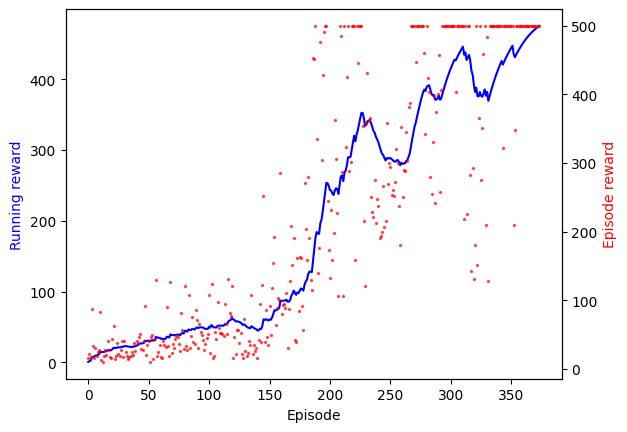

In [3]:
agent1 = Agent(
    env=gym.make("CartPole-v1"),
    model=ActorCritic(4, 2, 64))  

agent1.train(max_episodes=1000, max_steps_per_episode=500, lr=5e-3, gamma=0.99)

Next, we create a new agent and load our model that was saved during the training in the cell above. Then we infer our model in a new episode and create an animation of this episode:

In [4]:
agent2 = Agent(
    env=gym.make("CartPole-v1"),
    model=ActorCritic(4, 2, 64),
    path_model_pars="./model")  

agent2.infer(max_steps_per_episode=500)

Stopped at step 499


Animation of this episode:
![display image](./animation.gif)